Importing Dependencies

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

Data Exploration

In [26]:
data = pd.read_csv('data/train.csv')
missing_vals = data.isnull().sum()
print(missing_vals)

Id                                         0
date                                       0
Lagging_Current_Reactive.Power_kVarh       0
Leading_Current_Reactive_Power_kVarh     119
CO2(tCO2)                                  0
Lagging_Current_Power_Factor               0
Leading_Current_Power_Factor              76
NSM                                        0
WeekStatus                              1774
Day_of_week                             1774
Load_Type                                  0
Usage_kWh                                  0
dtype: int64


Visualization of Numerical Outliers

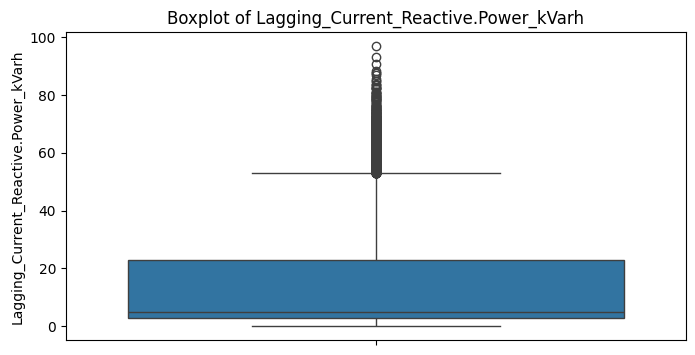

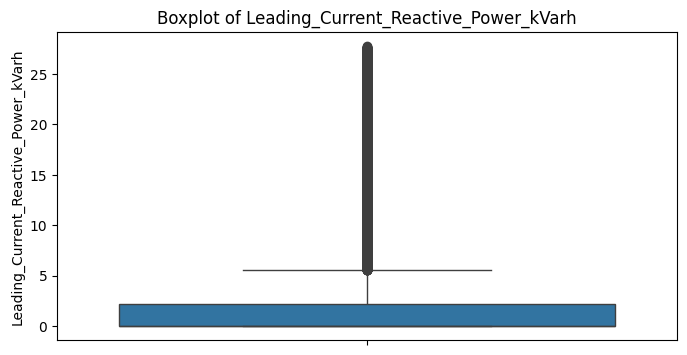

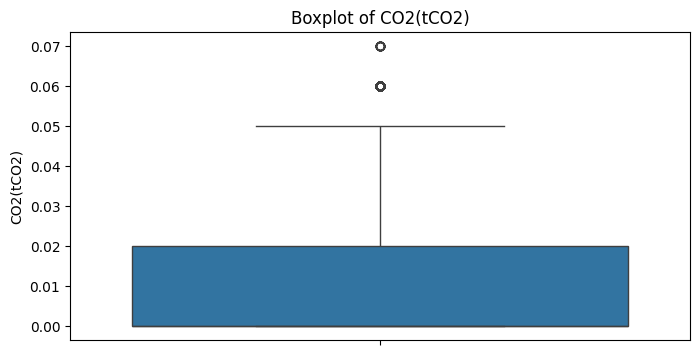

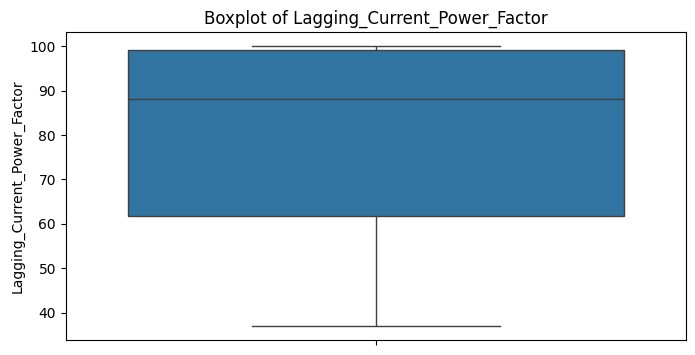

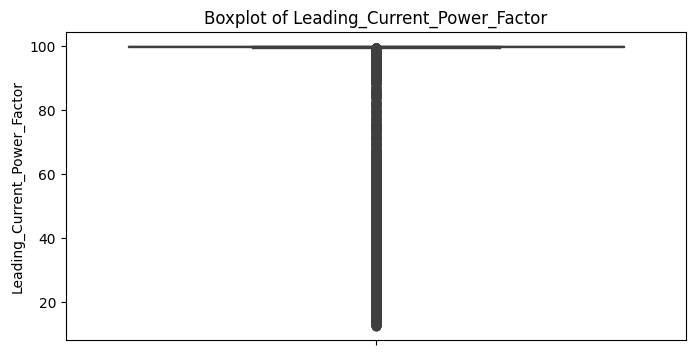

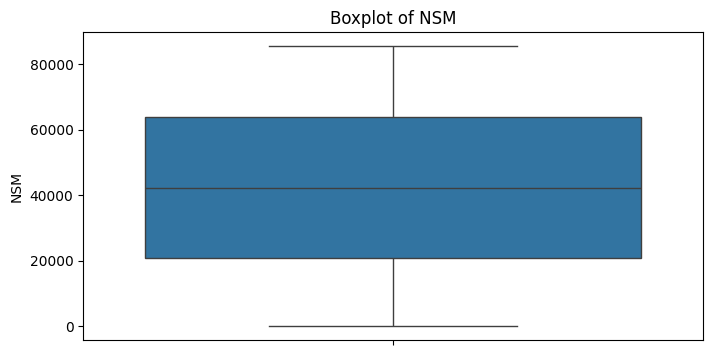

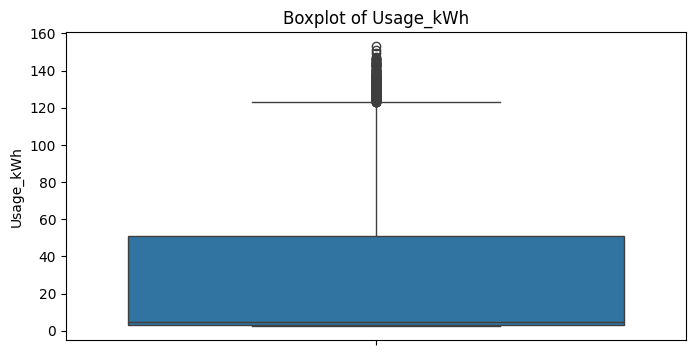

In [27]:
numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('Id')

for column in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

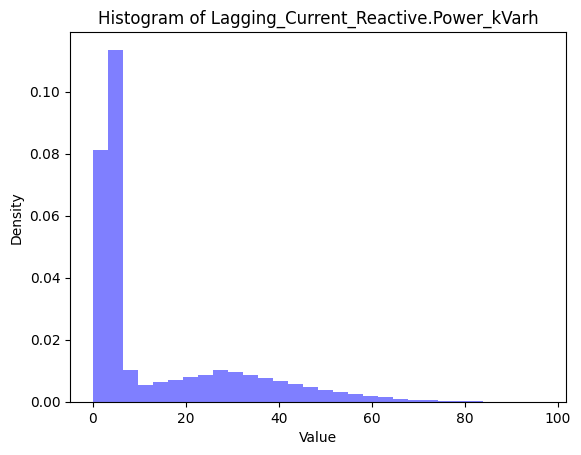

D'Agostino's K^2 Test for Lagging_Current_Reactive.Power_kVarh: p-value = 0.0


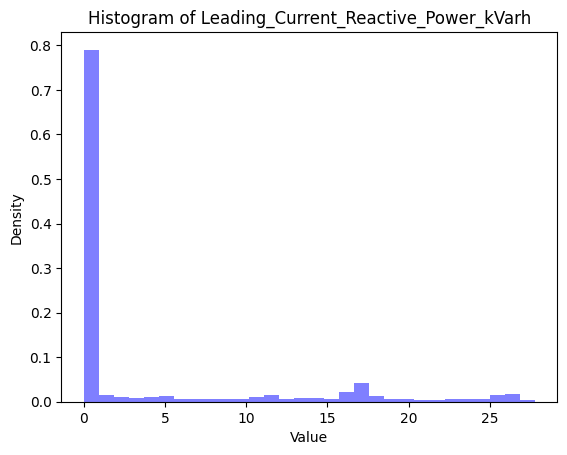

D'Agostino's K^2 Test for Leading_Current_Reactive_Power_kVarh: p-value = nan


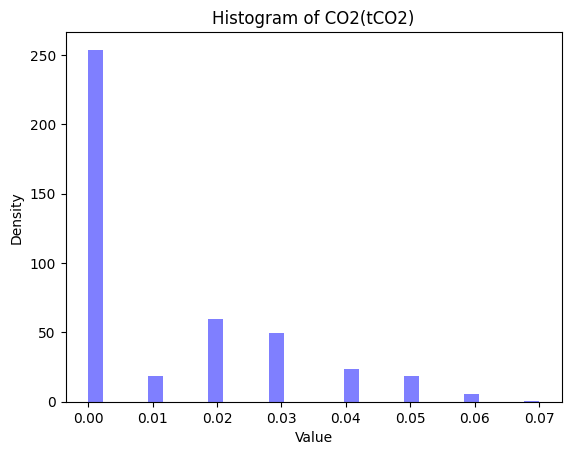

D'Agostino's K^2 Test for CO2(tCO2): p-value = 0.0


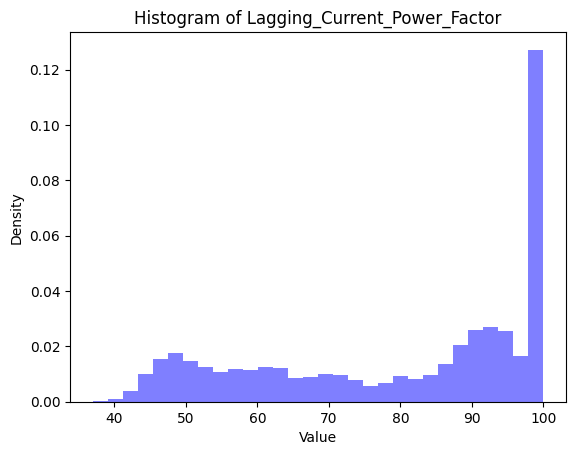

D'Agostino's K^2 Test for Lagging_Current_Power_Factor: p-value = 0.0


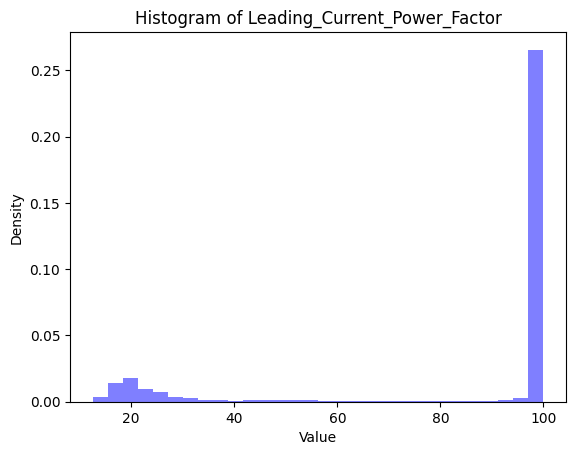

D'Agostino's K^2 Test for Leading_Current_Power_Factor: p-value = nan


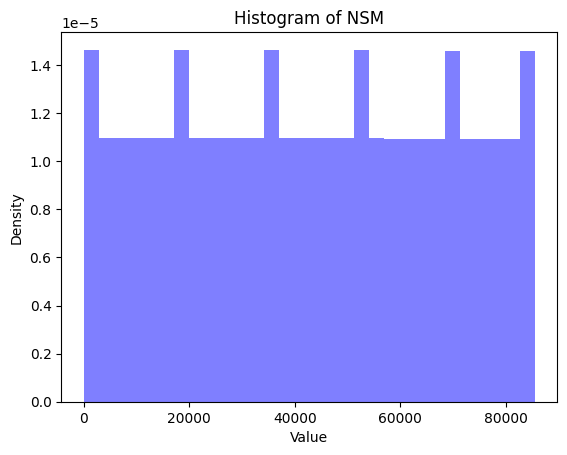

D'Agostino's K^2 Test for NSM: p-value = 0.0


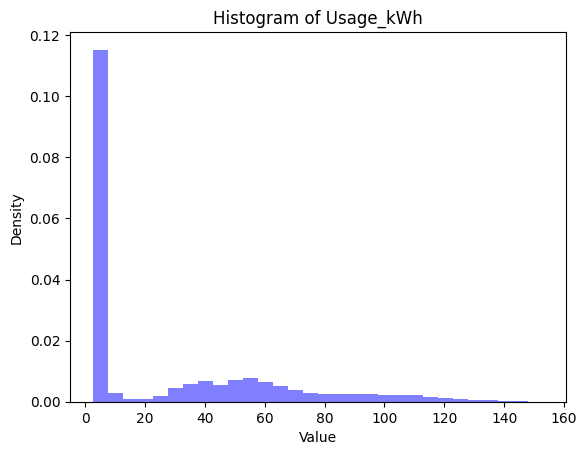

D'Agostino's K^2 Test for Usage_kWh: p-value = 0.0


In [28]:
for column in numerical_columns:
    plt.hist(data[column], bins=30, density=True, alpha=0.5, color='b')
    plt.title('Histogram of {}'.format(column))
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()
    
    normaltest_statistic, normaltest_p_value = stats.normaltest(data[column])
    print(f"D'Agostino's K^2 Test for {column}: p-value = {normaltest_p_value}")


Categorical Columns' Outliers

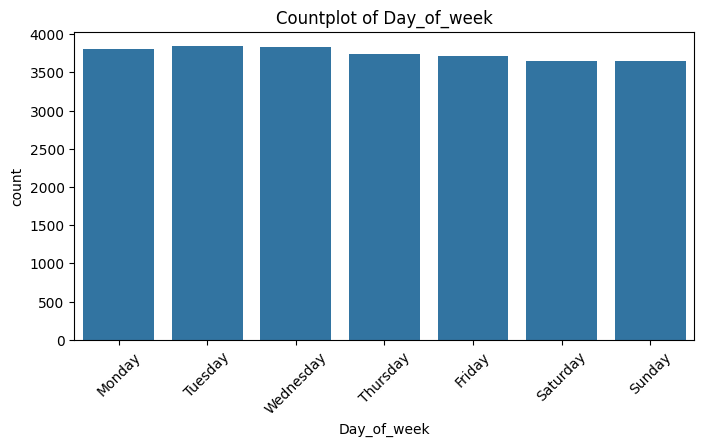

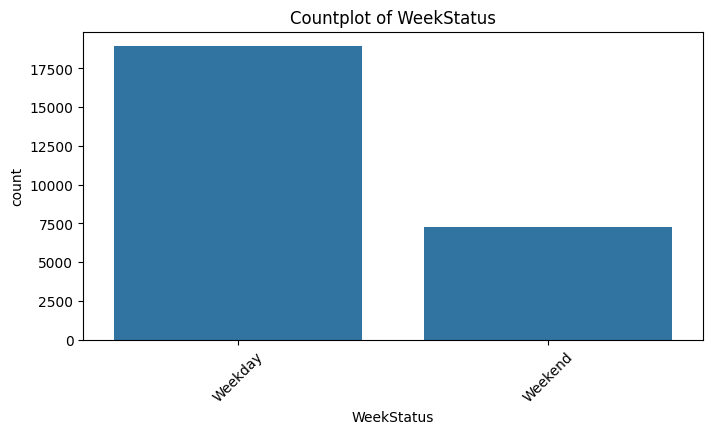

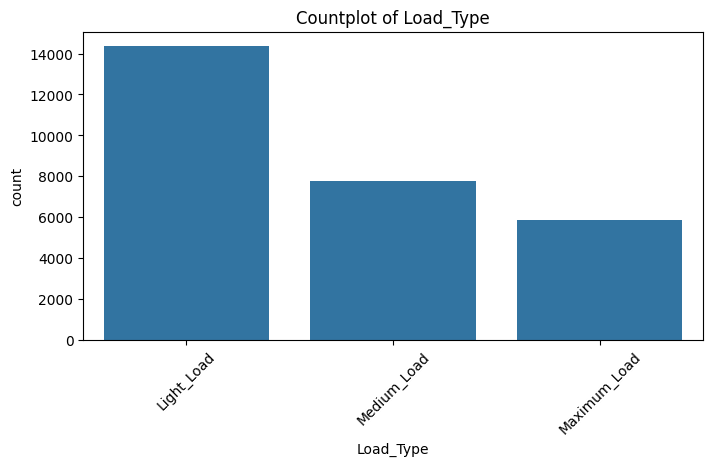

In [29]:
categorical_columns = ['Day_of_week', 'WeekStatus', 'Load_Type']

for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=column)
    plt.title(f'Countplot of {column}')
    plt.xticks(rotation=45)
    plt.show()

Data Cleaning

    Handle Missing Values

Dropping Missing Values

In [30]:
data_drop = data.copy()
data_drop = data_drop.dropna(subset=data.columns[1:])
data_drop = data_drop.drop_duplicates()
print("Original:", data.shape)
print("After dropping rows with missing values:", data_drop.shape)

Original: (27999, 12)
After dropping rows with missing values: (26030, 12)


Imputing Missing Values

In [31]:
#Numerical Imputation

data_imputed = data.copy()
data_imputed[numerical_columns] = data_imputed[numerical_columns].fillna(data_imputed[numerical_columns].mean())

#Categorical Imputation
categorical_features = ['Day_of_week', 'Load_Type', 'WeekStatus']

for feature in categorical_features:
    mode_value = data_imputed[feature].mode()[0]
    data_imputed[feature] = data_imputed[feature].fillna(mode_value)

print(data_imputed.isnull().sum())

Id                                      0
date                                    0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
Usage_kWh                               0
dtype: int64


    Handle Outliers

Using Z-Score Imputation(Under Improvement)

In [32]:
#Calculating Z-score
z_score_drop = data_drop[numerical_columns].apply(stats.zscore)
z_score_imputed = data_imputed[numerical_columns].apply(stats.zscore)

threshold = 3

#Identifying outliers
outliers_drop = data_drop[z_score_drop.abs() > threshold]
outliers_imputed = data_imputed[z_score_imputed.abs() > threshold]

#Removing Outliers
data_zscore_drop = data_drop[z_score_drop.abs() <= threshold]
data_zscore_imputed = data_imputed[z_score_imputed.abs() <= threshold]

print(data_zscore_drop.head())
print(data_zscore_imputed.head())

   Id date  Lagging_Current_Reactive.Power_kVarh  \
0 NaN  NaN                                  2.95   
1 NaN  NaN                                  4.46   
2 NaN  NaN                                  3.28   
3 NaN  NaN                                  3.56   
4 NaN  NaN                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                         100.0   900   
1                         66.77                         100.0  1800   
2                         70.28                         100.0  2700   
3                         68.09                         100.0  3600   
4      

After Filtering (Dropped) -> Z-Score Imputation

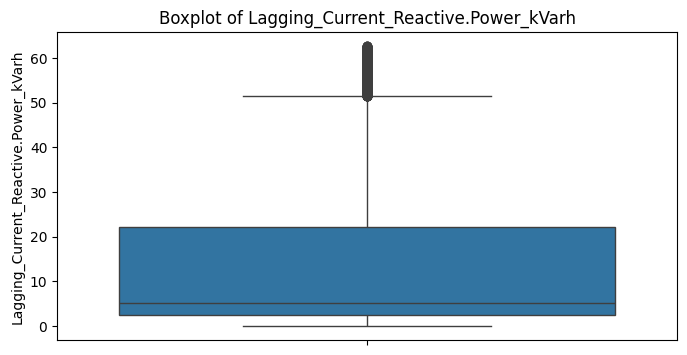

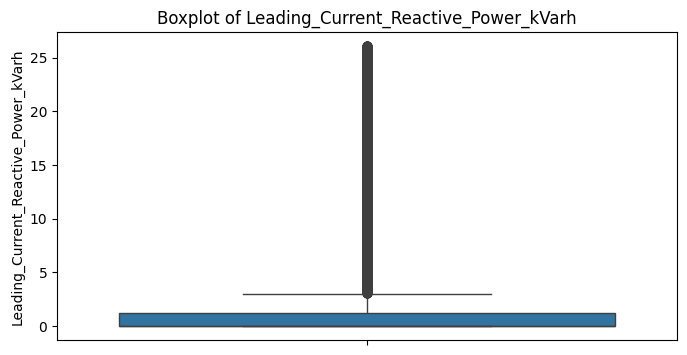

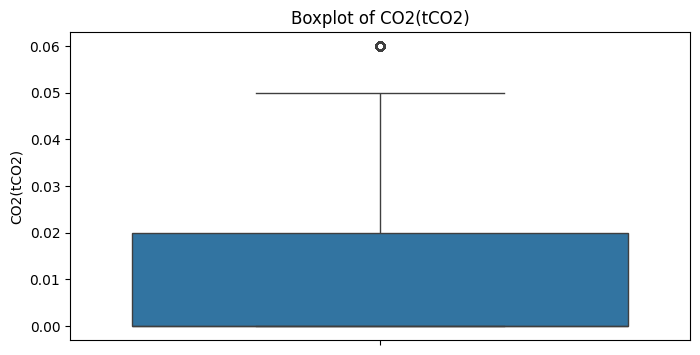

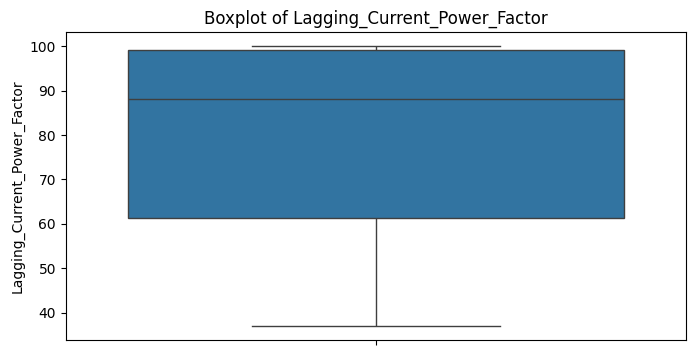

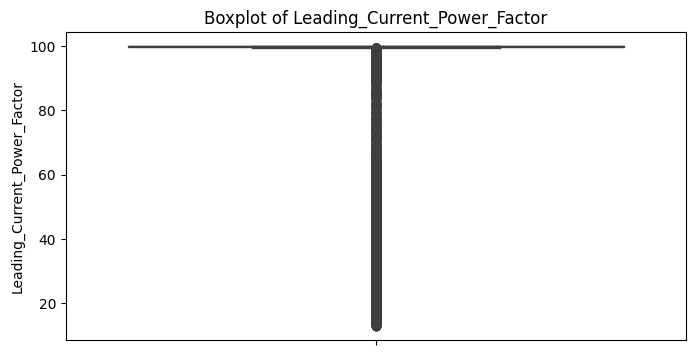

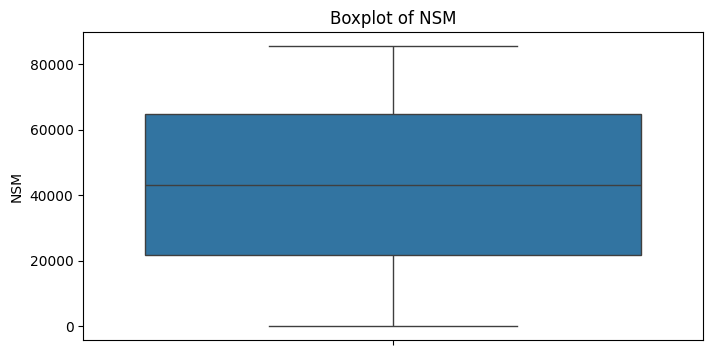

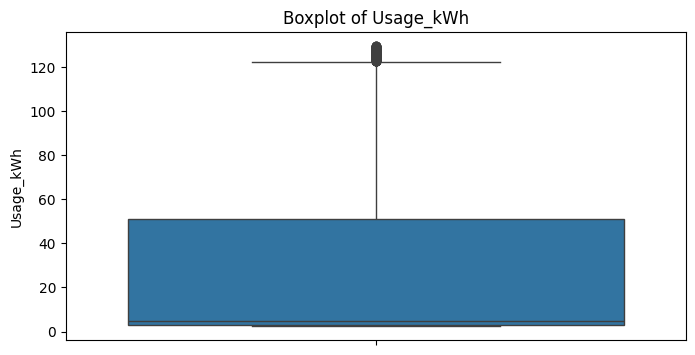

In [33]:
for column in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data_zscore_drop[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

After Filtering (Imputed) -> Z-Score Imputation

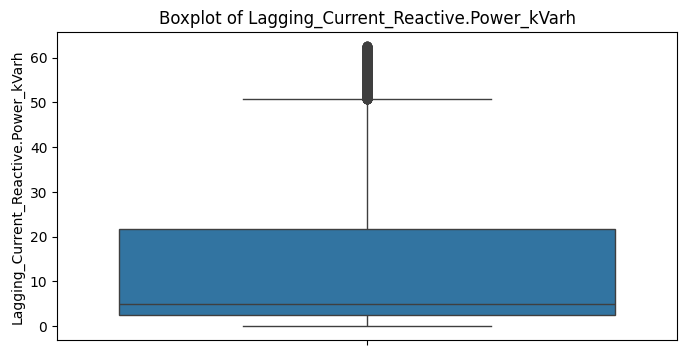

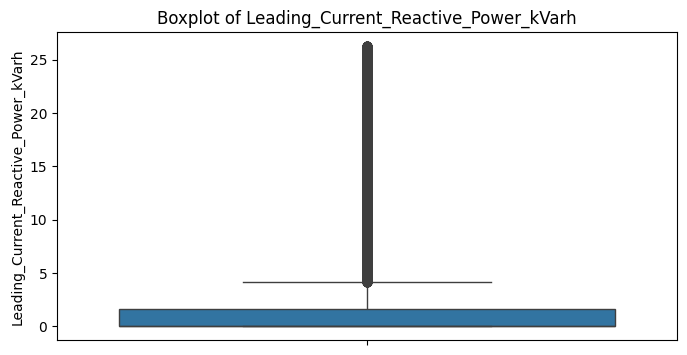

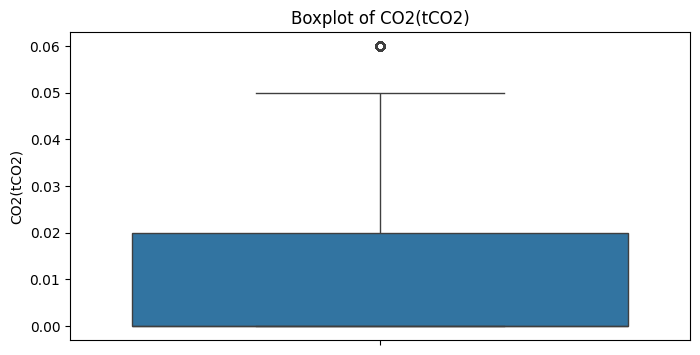

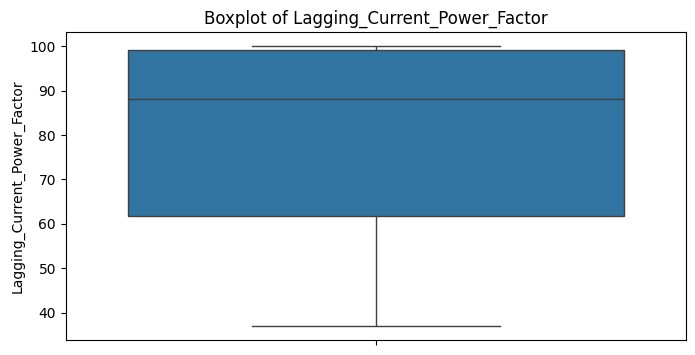

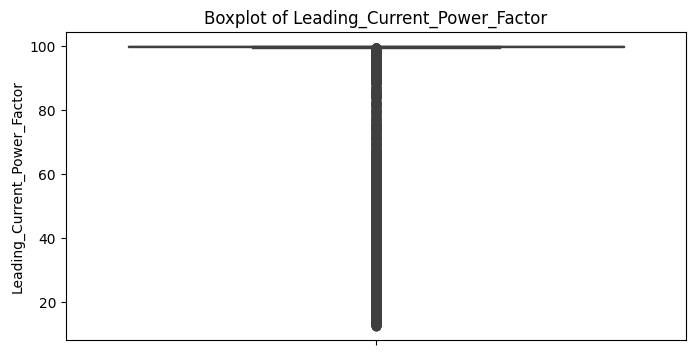

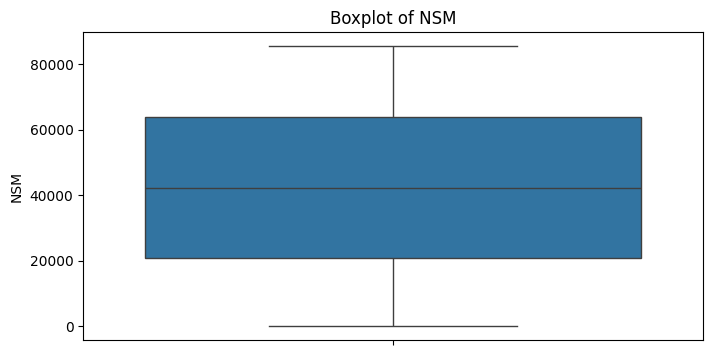

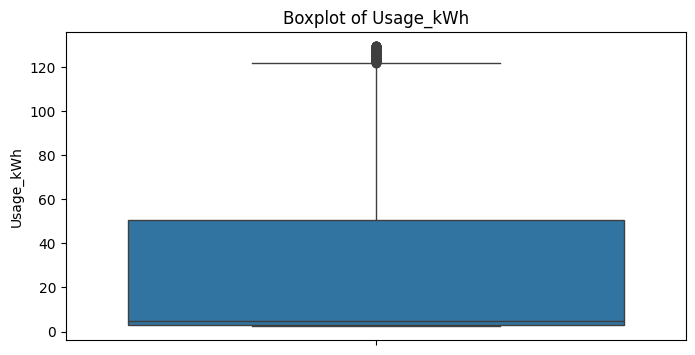

In [34]:
for column in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data_zscore_imputed[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

Using IQR Imputation

In [35]:

iqr_columns = ['Lagging_Current_Reactive.Power_kVarh', 'Lagging_Current_Power_Factor', 'Usage_kWh']

data_no_outliers_drop = data_drop.copy()

outlier_bounds = {}

for column in iqr_columns:
    Q1 = data_drop[column].quantile(0.25)
    Q3 = data_drop[column].quantile(0.75)
    IQR = Q3 - Q1
    print('Q:')
    print(Q1)
    print(Q3)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print("Threshhold:")
    print(lower_bound)
    print(upper_bound)


    outlier_bounds[column] = (lower_bound, upper_bound)

for column in iqr_columns:
    lower_bound, upper_bound = outlier_bounds[column]
    
    data_no_outliers_drop = data_no_outliers_drop[(data_no_outliers_drop[column] >= lower_bound) & (data_no_outliers_drop[column] <= upper_bound)]

data_no_outliers_drop.reset_index(drop=True, inplace=True)

# data_no_outliers_drop.to_csv('data_no_outliers_drop.csv', index=False)

data_no_outliers_imputed = data_imputed.copy()

outlier_bounds = {}

for column in iqr_columns:
    Q1 = data_imputed[column].quantile(0.25)
    Q3 = data_imputed[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_bounds[column] = (lower_bound, upper_bound)

for column in iqr_columns:
    lower_bound, upper_bound = outlier_bounds[column]
    
    data_no_outliers_imputed = data_no_outliers_imputed[(data_no_outliers_imputed[column] >= lower_bound) & (data_no_outliers_imputed[column] <= upper_bound)]

data_no_outliers_imputed.reset_index(drop=True, inplace=True)

# data_no_outliers_imputed.to_csv('data_no_outliers_imputed.csv', index=False)

print(data_no_outliers_drop.shape[0])
print(data_no_outliers_imputed.shape[0])


Q:
2.74
23.14
Threshhold:
-27.86
53.739999999999995
Q:
61.2325
99.0775
Threshhold:
4.465000000000003
155.845
Q:
3.13
51.3
Threshhold:
-69.125
123.55499999999999
25175
26995


After Filtering (Dropped) -> IQR Imputed

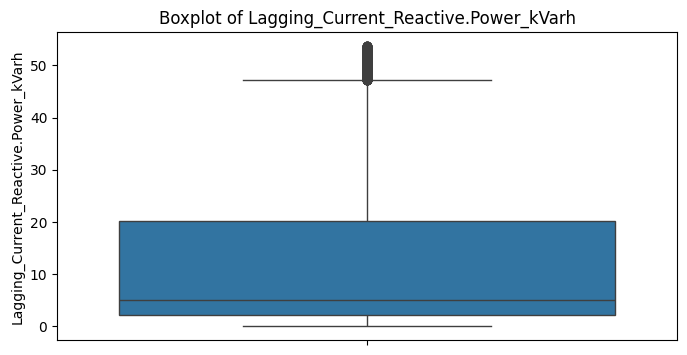

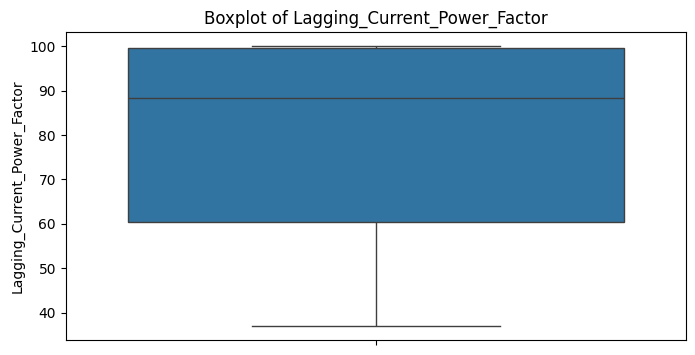

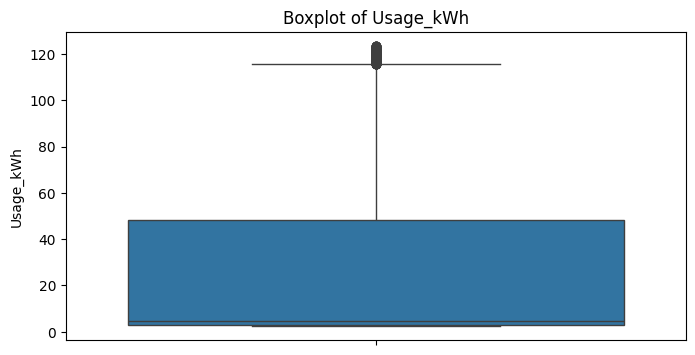

In [36]:
for column in iqr_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data_no_outliers_drop[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

After Filtering (Imputed) -> IQR Imputed

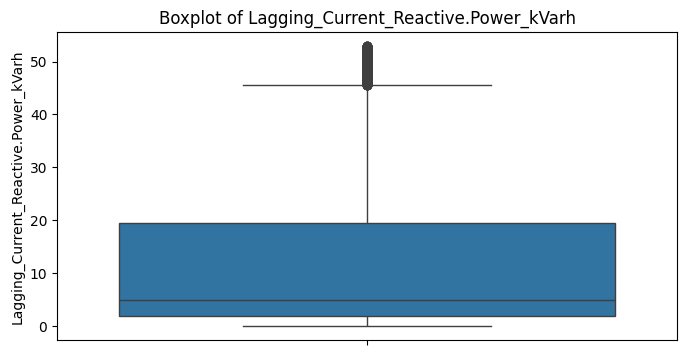

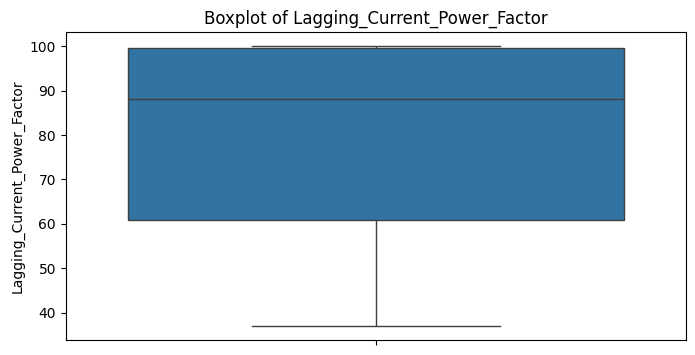

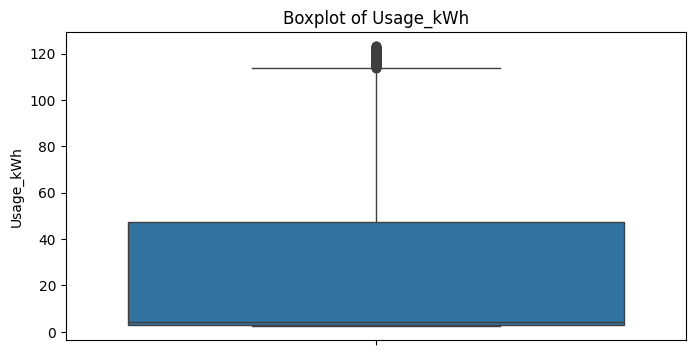

In [37]:
for column in iqr_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data_no_outliers_imputed[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

Removing Multiple Features

In [38]:
# data_drop_featureDrop = data_no_outliers_drop.drop(columns=['Leading_Current_Reactive_Power_kVarh', 'WeekStatus'])
# print(data_drop_featureDrop.shape[1])

In [39]:
# data_imputed_featureDrop = data_no_outliers_imputed.drop(columns=['Leading_Current_Reactive_Power_kVarh', 'WeekStatus'])
# print(data_imputed_featureDrop.shape[1])

    Encoding Categorical Features

Dropped Data

In [49]:
label_encoder = LabelEncoder()

data_no_outliers_drop['Load_Type'] = label_encoder.fit_transform(data_no_outliers_drop['Load_Type'])

print("Mapping of categories to encoded values for 'Load_Type':")
for category, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{category}: {encoded_value}")

data_no_outliers_drop_encoded = pd.get_dummies(data_no_outliers_drop, columns=['Day_of_week', "WeekStatus"])

print("Columns in data_no_outliers_drop_encoded:")
print(data_no_outliers_drop_encoded.columns)

data_no_outliers_drop_encoded.to_csv('data_no_outliers_drop_encoded.csv', index=False)


Mapping of categories to encoded values for 'Load_Type':
0: 0
1: 1
2: 2
Columns in data_no_outliers_drop_encoded:
Index(['Id', 'date', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'Load_Type', 'Usage_kWh', 'Day_of_week_Friday', 'Day_of_week_Monday',
       'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
       'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'WeekStatus_Weekday',
       'WeekStatus_Weekend'],
      dtype='object')


In [50]:
label_encoder = LabelEncoder()

data_no_outliers_imputed['Load_Type'] = label_encoder.fit_transform(data_no_outliers_imputed['Load_Type'])

print("Mapping of categories to encoded values for 'Load_Type':")
for category, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{category}: {encoded_value}")

data_no_outliers_imputed_encoded = pd.get_dummies(data_no_outliers_imputed, columns=['Day_of_week',"WeekStatus"])

print("Columns in data_no_outliers_imputed_encoded:")
print(data_no_outliers_imputed_encoded.columns)

data_no_outliers_imputed_encoded.to_csv('data_no_outliers_imputed_encoded.csv', index=False)


Mapping of categories to encoded values for 'Load_Type':
0: 0
1: 1
2: 2
Columns in data_no_outliers_imputed_encoded:
Index(['Id', 'date', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'Load_Type', 'Usage_kWh', 'Day_of_week_Friday', 'Day_of_week_Monday',
       'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
       'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'WeekStatus_Weekday',
       'WeekStatus_Weekend'],
      dtype='object')


Finding Correlations Between Features

In [72]:
#data_no_outliers_drop_encoded.drop(columns=['Id'], inplace=True)
#data_no_outliers_drop_encoded.drop(columns=['date'], inplace=True)

correlation_matrix = data_no_outliers_drop_encoded.corr()

highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

highly_correlated_features.discard('Usage_kWh')
data_drop_featureDrop = data_no_outliers_drop_encoded.drop(columns=highly_correlated_features)

print(highly_correlated_features)

data_drop_featureDrop.to_csv('data_drop_featureDrop.csv', index=False)

{'CO2(tCO2)', 'Leading_Current_Power_Factor', 'WeekStatus_Weekend'}


In [71]:
#data_no_outliers_imputed_encoded.drop(columns=['Id'], inplace=True)
#data_no_outliers_imputed_encoded.drop(columns=['data'], inplace=True)

correlation_matrix = data_no_outliers_imputed_encoded.corr()

highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

highly_correlated_features.discard('Usage_kWh')
data_imputed_featureDrop = data_no_outliers_imputed_encoded.drop(columns=highly_correlated_features)

print(highly_correlated_features)

data_imputed_featureDrop.to_csv('data_imputed_featureDrop.csv', index=False)

{'CO2(tCO2)', 'Leading_Current_Power_Factor', 'WeekStatus_Weekend'}


Scaling Features

In [74]:
scaler = StandardScaler()

columns_to_normalize = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'Lagging_Current_Power_Factor', 'NSM']

data_drop_featureDrop_normalized = data_drop_featureDrop.copy()
data_drop_featureDrop_normalized[columns_to_normalize] = scaler.fit_transform(data_drop_featureDrop_normalized[columns_to_normalize])

data_drop_featureDrop_normalized.to_csv('data_drop_featureDrop_normalized.csv', index=False)


In [ ]:
scaler = StandardScaler()

columns_to_normalize = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'Lagging_Current_Power_Factor', 'NSM']

data_imputed_featureDrop_normalized = data_imputed_featureDrop.copy()
data_imputed_featureDrop_normalized[columns_to_normalize] = scaler.fit_transform(data_imputed_featureDrop_normalized[columns_to_normalize])

data_imputed_featureDrop_normalized.to_csv('data_imputed_featureDrop_normalized.csv', index=False)
